# Mid-term Project: Implementing Object Detection on a Dataset

## Libraries

In [ ]:
import pandas as pd
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from time import time
from tqdm import tqdm
import os
import joblib
import matplotlib.pyplot as plt

## Data Processing

In [ ]:
#Correct the 'filepaths' column in order to train.



csv_file_path = "/content/drive/MyDrive/csst106-midterms/butterflies and moths.csv"
data = pd.read_csv(csv_file_path)

#The correction
prefix_path = "/content/drive/MyDrive/"
data['filepaths'] = prefix_path + data['filepaths'].astype(str)

# Save the updated CSV file
data.to_csv("/content/drive/MyDrive/csst106-midterms/butterflies_and_moths_updated.csv", index=False)

print("Filepaths updated successfully!")


Filepaths updated successfully!


## HOG Training

In [ ]:
def load_images_and_extract_hog_features_from_csv(csv_file, image_size=(128, 128)):
    features = []
    labels = []

    # Load CSV file
    data = pd.read_csv(csv_file_path)

    # Progress bar so I know how long to wait.
    for index, row in tqdm(data.iterrows(), total=data.shape[0], desc="Processing Images"):
        file_path = row['filepaths']
        label = row['labels']

        # Load image
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Could not load image at {file_path}")
            continue  #Catch for debugging

        # Resize image and extract HOG features
        img = cv2.resize(img, image_size)
        hog_features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), block_norm='L2-Hys')
        features.append(hog_features)
        labels.append(label)

    #Catch for debugging
    if not features:
        print("No images were loaded.")

    return np.array(features), np.array(labels)

# Load images and extract HOG features from CSV paths
csv_file_path = "/content/drive/MyDrive/csst106-midterms/butterflies_and_moths_updated.csv"
X, y = load_images_and_extract_hog_features_from_csv(csv_file_path)

# Check if X and y have data
if len(X) == 0 or len(y) == 0:
    print("Error: No data available for training. Please verify the dataset.")
else:
    # Splitting data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the classifier
    clf = SVC(kernel='linear')
    clf.fit(X_train, y_train)

    # Test the model
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)


Processing Images: 100%|██████████| 13594/13594 [1:08:48<00:00,  3.29it/s]


Accuracy: 0.38543582199337995


In [ ]:
# Calculate Accuracy, Precision, and Recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


# List to hold the times for each prediction
times = []

# Test speed over 100 images from the test set
for i in range(100):
    start_time = time()
    clf.predict([X_test[i]])  # Predict on one image
    end_time = time()

    # Append the time taken for this prediction
    times.append(end_time - start_time)

# Calculate average detection time per image
average_detection_time = sum(times) / len(times)
print("Average Detection Time per Image:", average_detection_time, "seconds")


Accuracy: 0.38543582199337995
Precision: 0.4013127708007508
Recall: 0.38543582199337995
Average Detection Time per Image: 0.08271707534790039 seconds


## Saving the model

In [ ]:
import joblib

# Save the trained model to a file
model_filename = "/content/drive/MyDrive/csst106-midterms/svm_hog_model.joblib"
joblib.dump(clf, model_filename)
print(f"Model saved as {model_filename}")


Model saved as /content/drive/MyDrive/csst106-midterms/svm_hog_model.joblib


## Predictions

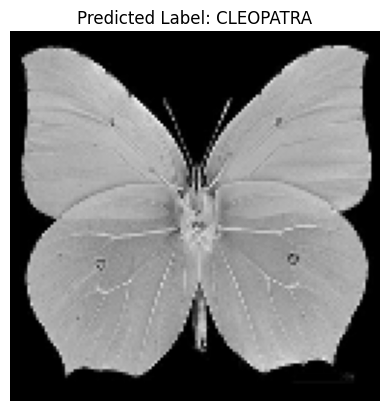

In [ ]:


# Load the saved model
model_filename = "/content/drive/MyDrive/csst106-midterms/svm_hog_model.joblib"
clf = joblib.load(model_filename)

def preprocess_image(image_path, image_size=(128, 128)):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")

    # Resize the image
    img_resized = cv2.resize(img, image_size)

    # Extract HOG features
    hog_features = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys')

    return hog_features, img_resized  # Return both HOG features and resized image

# Function to classify and display the image
def classify_and_display_image(image_path):
    # Preprocess the image and get HOG features and resized image
    hog_features, img_resized = preprocess_image(image_path)

    # Reshape HOG features for a single sample
    hog_features = hog_features.reshape(1, -1)

    # Predict the label
    predicted_label = clf.predict(hog_features)[0]

    # Display the image with predicted label
    plt.imshow(img_resized, cmap = 'gray')
    plt.title(f"Predicted Label: {predicted_label}")
    plt.axis('off')
    plt.show()

# Path to the image you want to classify
image_path = '/content/(MHNT)_Gonepteryx_cleopatra_-_Vaour_Tarn_France_-_male_ventral.jpg'
classify_and_display_image(image_path)
